In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from collections import Counter
import tensorflow as tf
from keras.applications import VGG16
from keras.models import Model
from keras.layers import Conv2D, Flatten, SeparableConv2D, MaxPooling2D, SpatialDropout2D, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.metrics import Precision, Recall, F1Score, AUC
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.regularizers import l2
import random
import pickle
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix

# **EDA**

## To extract the normal/pneumonia images:
- Find the path of the normal/pneumonia folder within the dataset
- Create a for loop to look for the filename in the normal/pneumonia folder directory and see if it ends with '.jpeg'
- Then join normal/pneumonia folder path with the filename.
- Then read the image.

In [2]:
# Create a function that loads in all the X-ray images with its corresponding labels.
def load_chest_xray_images(dataset_path, label_map):
    """
    Reads Normal and Pneumonia images from a dataset folder, and returns label image data.

    Parameters:
    - dataset_path (str): Path to the dataset folder.
    - label_map (dict): Dictionary mapping label names to numerical values.

    Returns:
    - X (list): List of images.
    - y (list): List of corresponding labels.
    - image_sizes (list): List of tuples containing image dimensions (height, width).
    - pixel_ranges (list): List of tuples with (min, max) pixel values for each image.
    """

    # Initialise the empty lists to hold the images, labels, image size, and pixel intensity range.
    X = []
    y = []
    image_sizes = []
    pixel_ranges = []

    # Process Normal Images.
    normal_folder = os.path.join(dataset_path, "NORMAL") # joins the dataset folder path with the Normal folder within it.
    for filename in os.listdir(normal_folder): # Loops through the filename in the normal_folder path.
        if filename.endswith(('.jpg', 'jpeg', '.png')): # Checks in the file ends with the options.
            img_path = os.path.join(normal_folder, filename) # joins the normal_folder path with the filename.

            # Read the image.
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

            # Store the images and labels extracted.
            X.append(img)
            y.append(label_map['Normal'])
            image_sizes.append(img.shape)
            pixel_ranges.append((img.min(), img.max()))

    # Process Pneumonia Images.
    pneumonia_folder = os.path.join(dataset_path, "PNEUMONIA") # joins the dataset folder path with the Pneumonia folder within it.
    for filename in os.listdir(pneumonia_folder): # Loops through the filename in the pneuomonia_folder path.
        if filename.endswith(('.jpg', 'jpeg', '.png')): # Checks in the file ends with the options.
            img_path = os.path.join(pneumonia_folder, filename) # joins the pneumonia_folder path with the filename.
        
            # Determine label for filename.
            if 'virus' in filename.lower(): # Checks is 'virus' is in the file name.
                label = label_map['Viral Pneumonia'] # label is set as 'Viral Pneumonia'.
            elif 'bacteria' in filename.lower(): # Checks is 'bacteria' is in the file name.
                label = label_map['Bacterial Pneumonia'] # label is set as 'Bacterial Pneumonia'.
            else:
                print("image is neither bacterial or viral pneumonia")
                continue # Skip unknown images.

            # Read image.
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

            # Store the images and labels extracted.
            X.append(img)
            y.append(label)
            image_sizes.append(img.shape)
            pixel_ranges.append((img.min(), img.max()))

    return X, y, image_sizes, pixel_ranges # Return all the data

In [3]:
# Define the dataset path.
dataset_path = r"C:\Users\arifm\Desktop\Digital Futures\Training\Capstone\Dataset"

In [4]:
# Define the label mapping.
label_map = {
    'Normal': 0,
    'Viral Pneumonia': 1,
    'Bacterial Pneumonia': 2
}

In [5]:
# Load images and labels.
X, y, image_sizes, pixel_ranges = load_chest_xray_images(dataset_path, label_map)

In [6]:
# Train-test split to avoid data leakage before EDA.
X_train, X_test, y_train, y_test, image_sizes_train, image_sizes_test, pixel_ranges_train, pixel_ranges_test = train_test_split(X, 
                                                                                                                                y,
                                                                                                                                image_sizes,
                                                                                                                                pixel_ranges, 
                                                                                                                                test_size=0.2, 
                                                                                                                                stratify=y, 
                                                                                                                                random_state=42, 
                                                                                                                                shuffle=True)

In [7]:
print(set(y_train))
print(set(y_test))

{0, 1, 2}
{0, 1, 2}


In [8]:
y_test;

In [9]:
# Check if the split was completed correctly.
print(f"Total samples before split: {len(X)}")
print(f"Training samples: {len(X_train)}, Testing samples: {len(X_test)}")
print(f"Training labels: {len(y_train)}, Testing labels: {len(y_test)}")
print(f"Training image sizes: {len(image_sizes_train)}, Testing image sizes: {len(image_sizes_test)}")
print(f"Training pixel ranges: {len(pixel_ranges_train)}, Testing pixel ranges: {len(pixel_ranges_test)}")

Total samples before split: 5856
Training samples: 4684, Testing samples: 1172
Training labels: 4684, Testing labels: 1172
Training image sizes: 4684, Testing image sizes: 1172
Training pixel ranges: 4684, Testing pixel ranges: 1172


In [10]:
# Select a random index before the split.
index = 10  # Change to any valid index.
print(f"Before Split - Image {index}: Label: {y[index]}, Size: {image_sizes[index]}, Pixel Range: {pixel_ranges[index]}") # Prints the metadata of a random image before train-test-split.

# Convert lists to NumPy arrays for easier comparison.
X_train_np = np.array(X_train, dtype=object) # object as images are not fixed-size numbers.
X_test_np = np.array(X_test, dtype=object)

# Find the index in X_train.
index_train = np.where([np.array_equal(X[index], img) for img in X_train_np])[0] # Loops through X_train_np and checks if each image matches X[index] and extrats the indices where the match is found.
index_test = np.where([np.array_equal(X[index], img) for img in X_test_np])[0] # Same but for the test set.

if len(index_train) > 0: # Exists in train set.
    index_train = index_train[0] # Extract the first matching index.
    print(f"Found in Training Set - Index: {index_train}, Label: {y_train[index_train]}, Size: {image_sizes_train[index_train]}, Pixel Range: {pixel_ranges_train[index_train]}") # Prints metadata.
elif len(index_test) > 0: # Exist in test set.
    index_test = index_test[0] # Extract the first matching index.
    print(f"Found in Testing Set - Index: {index_test}, Label: {y_test[index_test]}, Size: {image_sizes_test[index_test]}, Pixel Range: {pixel_ranges_test[index_test]}")
else:
    print("Error: Image not found in split sets!")

Before Split - Image 10: Label: 0, Size: (2155, 2444), Pixel Range: (0, 255)
Found in Training Set - Index: 399, Label: 0, Size: (2155, 2444), Pixel Range: (0, 255)


In [11]:
# Create a function to check the images.
def display_images(X_train, y_train, image_sizes, pixel_ranges):
    """
    Displays the first three images from the train dataset with their sizes and pixel value ranges using Seaborn.

    Parameters:
    - X_train (list): List of train images.
    - y_train (list): List of corresponding labels.
    - image_sizes (list): List of tuples with image dimensions.
    - pixel_ranges (list): List of tuples with pixel intensity ranges.
    """
    fig = plt.figure(figsize=(15,5)) # Create a figure.
    axes = fig.subplots(1, 3) # Create 3 subplots within the figure.

    for i, ax in enumerate(axes): # Loops through each subplot (axes) in the figure and display an image.
        sns.heatmap(X_train[i], cmap="gray", cbar=True, xticklabels=False, yticklabels=False, ax=ax) # Plots as a heatmap in greyscale with color bar and no axis labels.
        ax.set_title(f"Size: {image_sizes[i]}\nPixel Range: {pixel_ranges[i]}\nLabel: {y_train[i]}") # Sets the titles of each image as the dimensions and pixel value range and label.
        print(f"Image {i}: Size = {image_sizes[i]}, Pixel Range = {pixel_ranges[i]}, Label = {y_train[i]}") # Prints metadata.

    plt.tight_layout() # Ensures proper spacing between images, preventing overlap.
    plt.show() # Displays the images.

Image 0: Size = (1317, 1857), Pixel Range = (0, 255), Label = 1
Image 1: Size = (1509, 2111), Pixel Range = (0, 255), Label = 2
Image 2: Size = (1837, 2031), Pixel Range = (0, 255), Label = 2


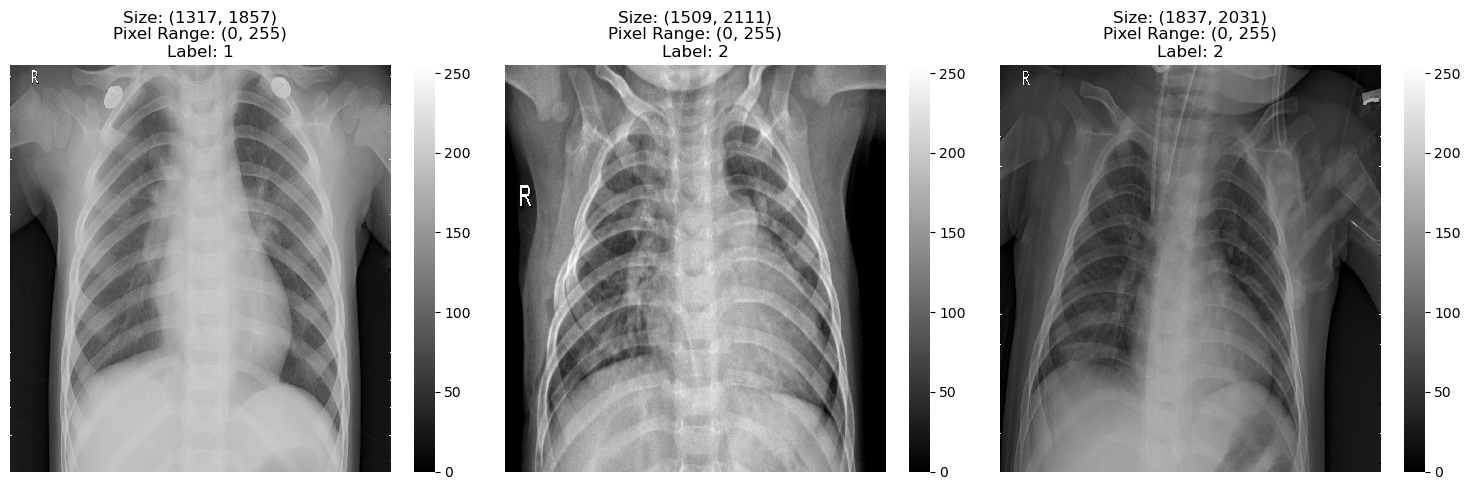

In [12]:
# Display three images with metadata in the train dataset.
display_images(X_train, y_train, image_sizes, pixel_ranges)

In [13]:
# Count occurrences of each label in the dataset.
label_counts = Counter(y_train)

# Print class distribution.
print("Class Distribution in Training Set:")
for label, count in label_counts.items():
    print(f"- {label}: {count} images")

Class Distribution in Training Set:
- 1: 1194 images
- 2: 2224 images
- 0: 1266 images


C:\Users\arifm\AppData\Local\Temp\ipykernel_30648\1492670986.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(label_counts.keys()), y=list(label_counts.values()), palette="coolwarm") # label_counts is a dictionary


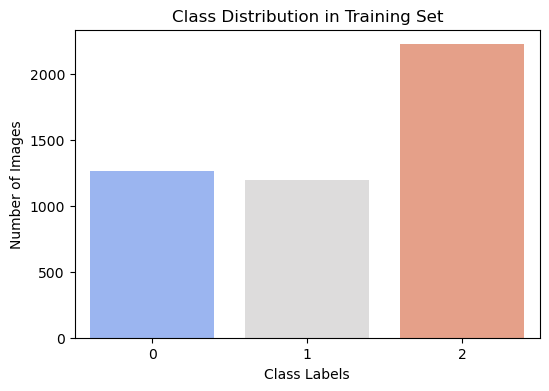

In [14]:
# Visualise class distribution.
plt.figure(figsize=(6, 4))
sns.barplot(x=list(label_counts.keys()), y=list(label_counts.values()), palette="coolwarm") # label_counts is a dictionary
plt.xlabel("Class Labels")
plt.ylabel("Number of Images")
plt.title("Class Distribution in Training Set")
plt.show()

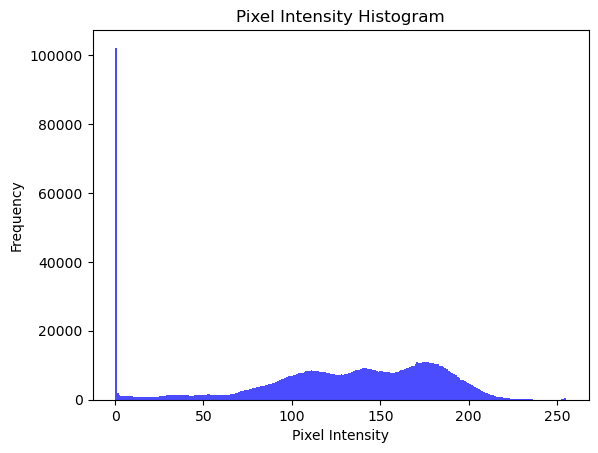

In [15]:
# Function to check pixel distribution.
def plot_pixel_histogram(image):
    plt.hist(image.ravel(), bins=256, color='blue', alpha=0.7)
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
    plt.title("Pixel Intensity Histogram")
    plt.show()

plot_pixel_histogram(X_train[1])

In [16]:
# Check for image blurriness.
def variance_of_laplacian(image):
    return cv2.Laplacian(image, cv2.CV_64F).var() # second-order derivative filter that detects edges. The output is a floating-point image. Higher variance, the sharper the image.

blur_scores = [variance_of_laplacian(img) for img in X_train] # applies the function to each image in the train dataset.
print(f"Average Blur Score: {np.mean(blur_scores)}") # Calculates the mean of all images.

Average Blur Score: 145.00592537544503


## **Pre-processing steps:**
- ~~All images are of different sizes which needs to be change to be inputted into the neural network.~~
- ~~The pixel range is between 0 and 255 which can cause unstable gradients and increased computational complexity. Therefore, needs to be normalised between 0 and 1.~~
- ~~After normalising, for CNN input dimension has to be expanded to include the channel dimension.~~
- ~~In the dataset there are 1266 normal images, 1194 viral pneumonia, and 2224 bacterial pneumonia. Due to the imbalance, data augmentation is required to balance the classes out to allow the model to learn each class equally.~~
- The pixel intensity distribution seems to various throughout the training dataset some are right skewed and some are well distributed with the exception of there being a lot of completely black pixels in the image.
- The average blur score for the dataset is 145 which is consider to mean that most images are sharp images.
- ~~`X_train, X_test` still needs to be changed into a numpy array after dimensions are constant throughout all images.~~

In [17]:
# Resize all images in X_train and X_test to (224, 224).
X_train = [cv2.resize(img, (224, 224)) for img in X_train]
X_test = [cv2.resize(img, (224, 224)) for img in X_test]

In [18]:
# Convert train set to Numpy arrays (needed for tensorflow).
X_train = np.array(X_train, dtype='float32')
y_train = np.array(y_train, dtype='int')

In [19]:
# Check if all image in train is resized.
X_train.shape

(4684, 224, 224)

In [20]:
# Convert test set to Numpy arrays (needed for tensorflow).
X_test = np.array(X_test, dtype='float32')
y_test = np.array(y_test, dtype='int')

In [21]:
# Check if all image in test is resized.
X_test.shape

(1172, 224, 224)

In [22]:
# Expand the dimensions on X_train for Neural Network use
X_train = np.expand_dims(X_train, axis=-1)

In [23]:
# Check of pixel intensity range for X_train before normalisation.
X_train[0];

In [24]:
# Check for the addition of the channel dimension.
X_train.shape # The 1 indicates that the images are in greyscale.

(4684, 224, 224, 1)

In [25]:
# Normalise X_test pixels to be between 0 and 1.
X_test = X_test / 255.0
X_test = np.expand_dims(X_test, axis=-1)

In [26]:
# Check for the addition of the channel dimension.
X_test.shape # The 1 indicates that the images are in greyscale.

(1172, 224, 224, 1)

In [27]:
# Check of pixel intensity range for X_test.
X_test[0];

In [28]:
# Define the augmentation generator.
datagen = ImageDataGenerator(
    rotation_range=15,      # Randomly roates images by up to +/- 15 degrees.
    width_shift_range=0.1,  # Shifts images horizontally by up to 10% oof the width.
    height_shift_range=0.1, # Shifts images vertically by up to 10% of the height.
    zoom_range=0.1,         # Randomly zooms in or out by up to 10%.
    shear_range=0.1,        # Apply shear transformation.
    brightness_range=[0.8, 1.2],  # Adjust brightness (80% - 120% of original).
    horizontal_flip=True,   # Randomly flips images horizontally (simulates left/right mirroring).
    fill_mode='reflect'     # Fills empty pixels (caused by the transformations) by mirroring nearby pixels instead of using black padding.
)

# Create a function that augments the normal and viral pneumonia images to have the same number as the bacterial.
def augment_images(X_class, num_augmented):
    """
    Augments a given class of images until the required count is reached.

    Parameters:
    - X_class (numpy array): Array of images from a specific class (0-255 range).
    - num_augmented (int): Number of additional images needed.

    Returns:
    - Augmented images as a numpy array (still in 0-255 range).
    """
    # Initalise a list that stores augmented images.
    augmented_images = []

    # Ensure images have a channel dimension.
    if X_class.ndim == 3: # Checks if images shape has a channel dimension.
        X_class = np.expand_dims(X_class, axis=-1)

    # Convert to float32 (required for augmentation using ImageDataGenerator)
    X_class = X_class.astype(np.float32)

    # Generate images in batches
    batch_size = min(32, num_augmented) # Uses 32 images per batch, unless images needed to augment is less then it uses that number.
    total_batches = (num_augmented // batch_size) + 1 # Finds how many batches are needed to generate the needed number of images.

    for _ in range(total_batches): # Loops through the number of batches needed amount of times.
        batch = datagen.flow(X_class, batch_size=batch_size, shuffle=True) # Generates a batch of augmented images from X_class and shuffles for diversity.

        for i in range(batch_size): # Loops through each image in the batch.
            augmented_img = batch.next()[0]  # Get augmented image from the batch.
            augmented_img = np.clip(augmented_img, 0, 255).astype(np.uint8)  # Converts it from float to int and ensure pixel values stay within 0-255.
            augmented_images.append(augmented_img) # Adds the processed image to the list.
            if len(augmented_images) >= num_augmented: # CHecks if the required number of augmented images has been reached.
                return np.array(augmented_images, dtype=np.uint8) # Reutrns the list in an array and as ints.

    return np.array(augmented_images, dtype=np.uint8)

In [29]:
# Separate class-specific images.
X_train_normal = np.array([X_train[i] for i in range(len(y_train)) if y_train[i] == 0]) # Creates a numpy array that contains only the images labelled as 0 (normal).
X_train_viral = np.array([X_train[i] for i in range(len(y_train)) if y_train[i] == 1]) # Creates a numpy array that contains only the images labelled as 1 (viral).

# Generate augmented images.
augmented_normal = augment_images(X_train_normal, 958) 
augmented_viral = augment_images(X_train_viral, 1030) 

# Verify results.
print(f"Augmented Normal shape: {augmented_normal.shape}") 
print(f"Augmented Viral shape: {augmented_viral.shape}") 

Augmented Normal shape: (958, 224, 224, 1)
Augmented Viral shape: (1030, 224, 224, 1)


In [30]:
# Check if images pixel range is maintained.
print(f"Max pixel value in augmented_normal: {augmented_normal.max()}")
print(f"Min pixel value in augmented_normal: {augmented_normal.min()}")
print(f"Max pixel value in augmented_viral: {augmented_viral.max()}")
print(f"Min pixel value in augmented_viral: {augmented_viral.min()}")

Max pixel value in augmented_normal: 255
Min pixel value in augmented_normal: 0
Max pixel value in augmented_viral: 255
Min pixel value in augmented_viral: 0


In [31]:
# Create a function that displays 2 images for the augmented normal and viral variables.
def display_augmented_images(augmented_normal, augmented_viral):
    """
    Displays 2 randomly selected images from augmented_normal and 2 from augmented_viral using Seaborn heatmaps.
    Ensures proper grayscale representation.

    Parameters:
    - augmented_normal (numpy array): Augmented images of Normal class.
    - augmented_viral (numpy array): Augmented images of Viral Pneumonia class.
    """
    # Randomly select 2 images from each class.
    normal_indices = random.sample(range(len(augmented_normal)), 2)
    viral_indices = random.sample(range(len(augmented_viral)), 2)

    # Create a 2x2 plot
    fig = plt.figure(figsize=(10, 8)) # Create a figure.
    axes = fig.subplots(2, 2) # Create 2x2 subplots within the figure.

    # Plot Normal Augmented Images (Row 1).
    for i, idx in enumerate(normal_indices):     
        img = augmented_normal[idx].squeeze() # Extracts the image at idx from augmented_normal and removes extra dimensions to ensure correct shape for visualisation.
        sns.heatmap(img,
                    cmap="gray",
                    cbar=False,
                    xticklabels=False,
                    yticklabels=False,
                    ax=axes[0, i], # Places the image in the first row and the i-th column.
                    vmin=0,
                    vmax=255) # Ensure grayscale intensity is correctly mapped.
        axes[0, i].set_title(f"Augmented Normal {idx}") # Title for each subplot.

    # Plot Viral Pneumonia Augmented Images (Row 2) same settings as above.
    for i, idx in enumerate(viral_indices):
        img = augmented_viral[idx].squeeze()
        sns.heatmap(img,
                    cmap="gray",
                    cbar=False,
                    xticklabels=False,
                    yticklabels=False,
                    ax=axes[1, i],
                    vmin=0,
                    vmax=255)
        axes[1, i].set_title(f"Augmented Viral {idx}")

    plt.tight_layout()
    plt.show()

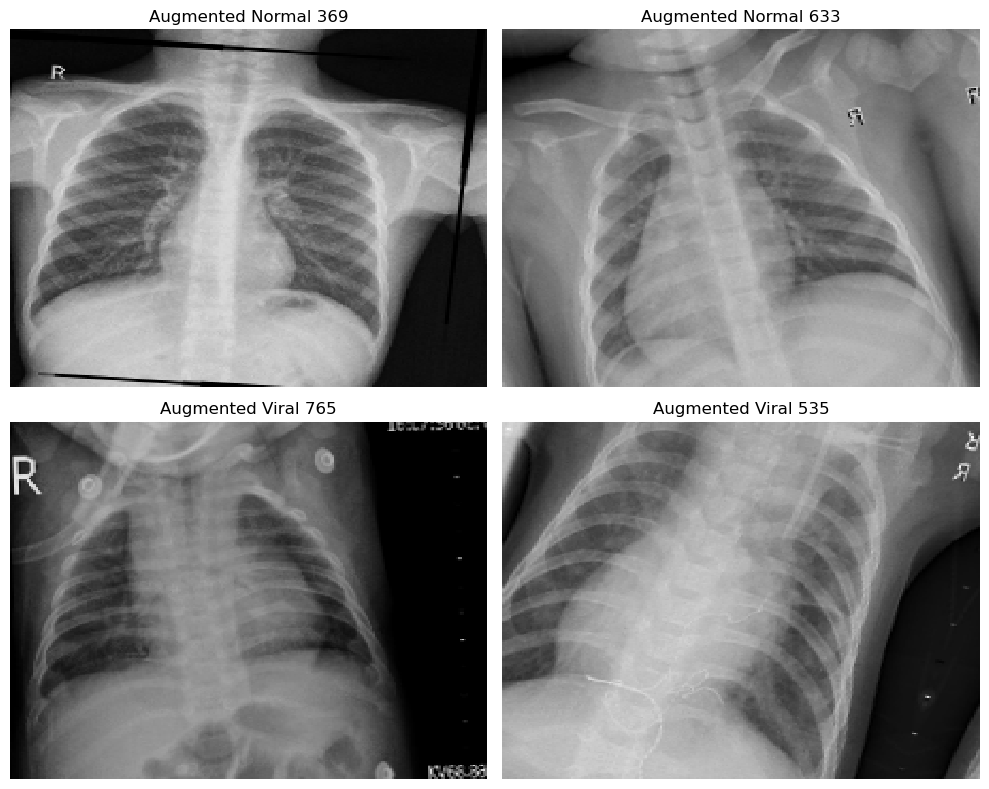

In [32]:
# Display the images.
display_augmented_images(augmented_normal, augmented_viral)

In [33]:
# Add augmented images and labels to training set.
X_train = np.concatenate((X_train, augmented_normal, augmented_viral), axis=0) # Combines all three datasets along the rows.
y_train = np.concatenate((y_train, np.array([0] * 958), np.array([1] * 1030)), axis=0) # Add the new labels to the y_train along the rows.

# Check final class distribution
print(f"Class distribution after augmentation: {Counter(y_train)}")

Class distribution after augmentation: Counter({1: 2224, 2: 2224, 0: 2224})


In [34]:
# Checks the X_train and y_train length match.
len(X_train) == len(y_train)

True

In [35]:
# Check shape of X_train and y_train
print(X_train.shape)
print(y_train.shape)

(6672, 224, 224, 1)
(6672,)


In [36]:
# Normalise X_train pixels to be between 0 and 1.
X_train = X_train / 255.0

In [37]:
X_train[0];

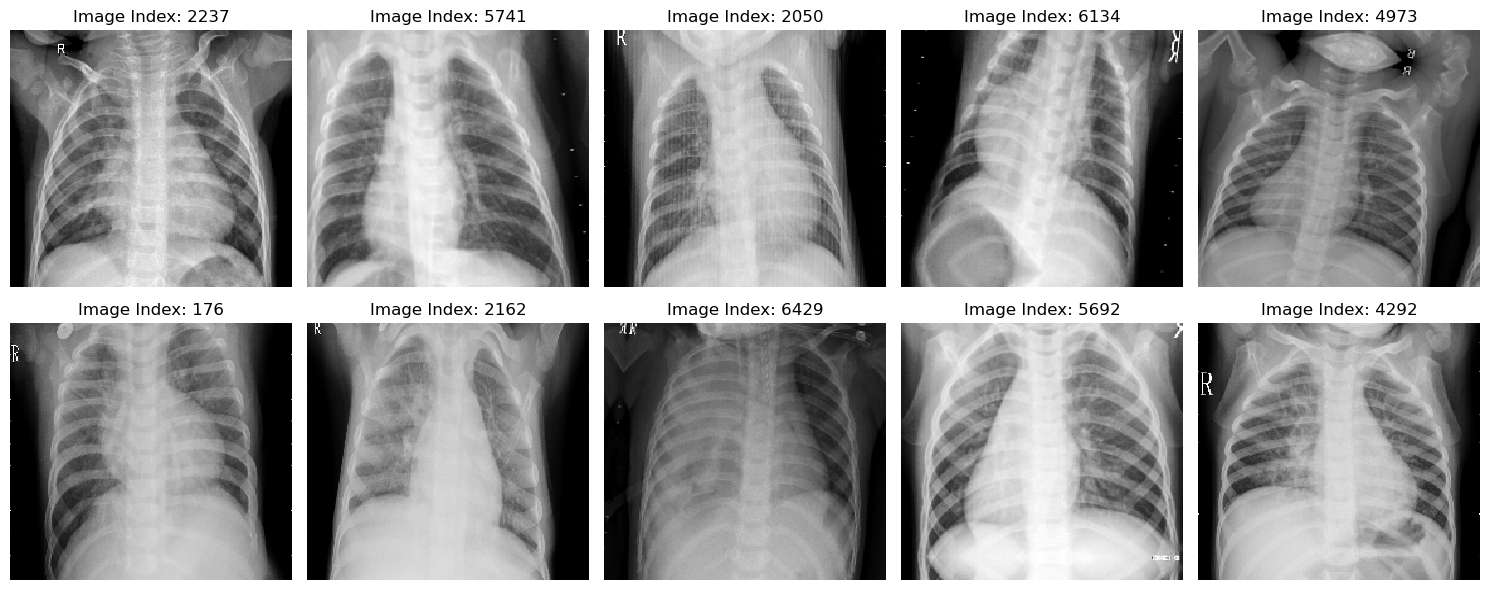

In [38]:
# Select 10 random indices
random_indices = np.random.choice(len(X_train), 10, replace=False) # Replace makes sure indices are unique and not repeated.

# Create subplots (2 rows, 5 columns)
fig = plt.figure(figsize=(15, 6))
axes = fig.subplots(2, 5)

# Plot each image
for i, ax in enumerate(axes.flat):  # Flatten the 2D axes array to loop over it
    img = X_train[random_indices[i]].squeeze()  # Extract image and remove extra dimensions
    
    sns.heatmap(img,
                cmap="gray",
                cbar=False,
                xticklabels=False,
                yticklabels=False,
                ax=ax,
                vmin=0,
                vmax=1)  # Keep grayscale range 0-1

    ax.set_title(f"Image Index: {random_indices[i]}")  # Set title to show the image index

plt.tight_layout()
plt.show()

# **Modelling**

- Create a custom model first
- Use the weights of a pre-trained VGG16 model for the first 3 convolutions (partial transfer learning)

In [39]:
# Create a custom model that has partial transfer learning for the first three convolutions from the VGG16 model.
def build_custom_model():
    """
    Creates a deeper CNN model for pneumonia classification with:
    - First 2 layers: Standard Conv2D + Spatial Dropout
    - Rest: SeparableConv2D + Spatial Dropout for efficiency
    - Uses first 3 convolutional layers from VGG16 (pre-trained)
    - Includes L2 Regularization and Batch Normalization to reduce overfitting
    """

    # Load VGG16 with pre-trained weights, exclude fully connected layers
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Freeze the first 3 convolutional layers
    for layer in base_model.layers[:6]:  # Conv1, Conv1, and Pool1
        layer.trainable = False

    # Custom Model: Start from the third pooling layer of VGG16
    x = base_model.get_layer('block2_pool').output  # Use features from VGG16 up to 'block2_pool'


    # Mid-level layers (SeparableConv2D)
    x = Conv2D(128, (3,3), activation='relu', padding='same', kernel_regularizer=l2(0.008), name="custom_conv1")(x)
    x = SpatialDropout2D(0.5, name="spatial_dropout1")(x)  # Added Spatial Dropout
    x = BatchNormalization(name="bn1")(x)
    x = MaxPooling2D((2,2), name="custom_pool1")(x)

    print("Shape before deep layers:", x.shape)

    # Deeper layers (More comple feature extraction)
    x = Conv2D(256, (3,3), activation='relu', padding='same', kernel_regularizer=l2(0.008), name="custom_conv2")(x)
    x = SpatialDropout2D(0.5, name="spatial_dropout2")(x)  # Added Spatial Dropout
    x = BatchNormalization(name="bn2")(x)
    x = MaxPooling2D((2,2), name="custom_pool2")(x)

    x = Conv2D(256, (3,3), activation='relu', padding='same', kernel_regularizer=l2(0.008), name="custom_conv3")(x)
    x = SpatialDropout2D(0.5, name="spatial_dropout3")(x)  # Added Spatial Dropout
    x = BatchNormalization(name="bn3")(x)
    x = MaxPooling2D((2,2), name="custom_pool3")(x)

    x = SeparableConv2D(256, (3,3), activation='relu', padding='same', kernel_regularizer=l2(0.008), name='sep_conv1')(x)
    x = SpatialDropout2D(0.5, name='spatial_dropout4')(x)
    x = BatchNormalization(name='bn4')(x)
    x = MaxPooling2D((2,2), name='sep_pool1', strides=(1,1))(x)

    print("Shape before deeper layers:", x.shape)

    # Very Deep layers (Gloabal abstract feature detection)
    x = SeparableConv2D(512, (3,3), activation='relu', padding='same', kernel_regularizer=l2(0.008), name="sep_conv2")(x)
    x = SpatialDropout2D(0.5, name="spatial_dropout5")(x)  # Added Spatial Dropout
    x = BatchNormalization(name="bn5")(x)
    x = MaxPooling2D((2,2), name="sep_pool2", strides=(1,1))(x)

    x = SeparableConv2D(512, (3,3), activation='relu', padding='same', kernel_regularizer=l2(0.008), name="sep_conv3")(x)
    x = SpatialDropout2D(0.5, name="spatial_dropout6")(x)  # Added Spatial Dropout
    x = BatchNormalization(name="bn6")(x)
    x = MaxPooling2D((2,2), name="sep_pool3", strides=(1,1))(x)

    x = SeparableConv2D(512, (3,3), activation='relu', padding='same', kernel_regularizer=l2(0.008), name="sep_conv4")(x)
    x = SpatialDropout2D(0.5, name="spatial_dropout7")(x)  # Added Spatial Dropout
    x = BatchNormalization(name="bn7")(x)
    x = MaxPooling2D((2,2), name="sep_pool4", strides=(1,1))(x)

    print("Shape before final pooling:", x.shape)

    x = GlobalAveragePooling2D(name="flatten")(x)  # Global Average Pooling to reduce overfitting and replaces Flatten.

    # Fully Connected Layers
    x = Dense(512, activation='relu', name="fc1")(x)
    x = Dropout(0.75, name="dropout1")(x)

    x = Dense(256, activation='relu', name="fc2")(x)
    x = Dropout(0.75, name="dropout2")(x)

    # Output Layer (3 Classes: Normal, Bacterial Pneumonia, Viral Pneumonia)
    output = Dense(3, activation='softmax', name="output")(x)

    # Define the final model
    model = Model(inputs=base_model.input, outputs=output)

    # Compile the model with Adam optimizer and custom metrics
    model.compile(
        optimizer=Adam(learning_rate=0.00007), 
        loss='categorical_crossentropy', 
        metrics=['accuracy', Precision(), Recall(), F1Score(), AUC(name="AUC")]
    )

    return model

# Build and print model summary
model = build_custom_model()
model.summary()

Shape before deep layers: (None, 28, 28, 128)
Shape before deeper layers: (None, 6, 6, 256)
Shape before final pooling: (None, 3, 3, 512)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     

In [40]:
# Define Training parameters
batch_size = 16
epochs = 90

In [41]:

# Convert grayscale (1-channel) to 3-channel grayscale to work with the VGG16 weights for the first 3 convolutional layers.
X_train = np.repeat(X_train, 3, axis=-1)
X_test = np.repeat(X_test, 3, axis=-1)

# Print shape to confirm
print("New Shape of X_train:", X_train.shape) 
print("New Shape of X_test:", X_test.shape)
print(y_train.shape)

New Shape of X_train: (6672, 224, 224, 3)
New Shape of X_test: (1172, 224, 224, 3)
(6672,)


In [42]:
# OHE y_train and y_test and aligning the its shape with the output of the model
y_train = to_categorical(y_train, num_classes=3)
y_test = to_categorical(y_test, num_classes=3)

In [43]:
print(y_train.dtype)
print(y_train.shape)
print("Model output shape:", model.output_shape)  # Should be (None, 3)
print(model)

float32
(6672, 3)
Model output shape: (None, 3)


In [44]:
len(y_test)

1172

In [45]:
np.unique(y_train)

array([0., 1.], dtype=float32)

In [42]:
# Train the model
history = model.fit(x=X_train,
                    y=y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    verbose=1)

# Save the trained model
model.save(r"C:\Users\arifm\Desktop\Digital Futures\Training\Capstone\models\model_4")

Epoch 1/90
417/417 [==============================] - 164s 389ms/step - loss: 7.0398 - accuracy: 0.3336 - precision: 0.3336 - recall: 0.3135 - f1_score: 0.3336 - AUC: 0.5040
Epoch 2/90
417/417 [==============================] - 163s 392ms/step - loss: 6.3469 - accuracy: 0.3596 - precision: 0.3609 - recall: 0.3246 - f1_score: 0.3594 - AUC: 0.5161
Epoch 3/90
417/417 [==============================] - 164s 393ms/step - loss: 5.8974 - accuracy: 0.3419 - precision: 0.3406 - recall: 0.2884 - f1_score: 0.3416 - AUC: 0.5143
Epoch 4/90
417/417 [==============================] - 161s 386ms/step - loss: 5.5648 - accuracy: 0.3536 - precision: 0.3589 - recall: 0.2776 - f1_score: 0.3529 - AUC: 0.5218
Epoch 5/90
417/417 [==============================] - 162s 389ms/step - loss: 5.2801 - accuracy: 0.3578 - precision: 0.3711 - recall: 0.2545 - f1_score: 0.3571 - AUC: 0.5353
Epoch 6/90
417/417 [==============================] - 161s 385ms/step - loss: 5.0545 - accuracy: 0.3633 - precision: 0.3773 - reca

INFO:tensorflow:Assets written to: C:\Users\arifm\Desktop\Digital Futures\Training\Capstone\models\model_4\assets


In [43]:
print("Model Loss Function:", model.loss)

Model Loss Function: categorical_crossentropy


In [44]:
print("X_train shape:", X_train.shape, "Data Type:", X_train.dtype)
print("y_train shape:", y_train.shape, "Data Type:", y_train.dtype)

X_train shape: (6672, 224, 224, 3) Data Type: float32
y_train shape: (6672, 3) Data Type: float32


In [45]:
test_loss, test_acc, test_precision, test_recall, test_f1, test_auc = model.evaluate(X_test, y_test)

print(f"✅ Test Accuracy: {test_acc}")
print(f"✅ Test Precision: {test_precision}")
print(f"✅ Test Recall: {test_recall}")
print(f"✅ Test F1-score: {test_f1}")
print(f"✅ Test AUC: {test_auc}")

37/37 [==============================] - 15s 396ms/step - loss: 0.6524 - accuracy: 0.7961 - precision: 0.8207 - recall: 0.7730 - f1_score: 0.7738 - AUC: 0.9346
✅ Test Accuracy: 0.7960751056671143
✅ Test Precision: 0.820652186870575
✅ Test Recall: 0.7730375528335571
✅ Test F1-score: [0.9262821  0.5628518  0.83235043]
✅ Test AUC: 0.9345513582229614


## **Model Changes:**
- The first model overfits alot. The training had everything on around 97% while the test gave 78%.
- Second model had L2 regularisation (0.001) in each convolutional layer to prevent overfitting. Had spatial dropout after every convolutional layer to reduce overfitting. Added early stopping to stop training when validation loss stops improving. Slight increase in the dropout in the fully convolutional layers.
- Third model had stronger augmentations to help to generalise better. A learning rate decay is introduced. Increased L2 regularisation. Increased dropout and model size is decreased. BEST MODEL YET. DID NOT OVERFIT ON THE TEST SET TOO MUCH BUT DID FOR THE VALIDATION SET!!!!
- model_3 is the best with 5% overfitting but the highest test metrics of 80-81%. Fix data augmentation to make sure the images augmentated are better quality. Increased model size (Conv2D).
- model_4 increase the model by one two layers. Filters 128, 256, and 512 has 3 convolutions each. increase L2 (0.008). increase dropout (0.75). Increase spatialdropout (0.5). Stopped maxpooling in the deeper feature extractions.
- Model 4 had no overfitting. slightly underfits. If trained longer could be the best and ideal model.

ASK ALEX WHY THIS MIGHT BE!!!!

# Do a cost function calculation
## 


In [46]:
# Find indices of viral and bacterial pneumonia images.
#viral_indices = np.where(y_test[:, 1] == 1)[0] # Label 1 for viral pneumonia.
#bacterial_indices = np.where(y_test[:, 2] == 1)[0] # Label 2 for bacterial pneumonia.

In [47]:
#len(viral_indices) # Checks the length of the viral indices.

299

In [48]:
#len(bacterial_indices) # Checks the length of the bacterial indices.

556

In [43]:
# Select one random index from each class.
#random_viral_idx = np.random.choice(viral_indices)
#random_bacterial_idx = np.random.choice(bacterial_indices)

In [44]:
#random_viral_idx # Check the random index from the viral indices.

398

In [45]:
#random_bacterial_idx # Check the random index from the bacterial indices.

890

In [47]:
# Save the randome viral and bacterial indices to a pickle file to ensure the same images will be used to show model interpretability.
#with open("selected_indices.pkl", "wb") as f:
    #pickle.dump({"random_viral_idx": random_viral_idx, "random_bacterial_idx": random_bacterial_idx}, f)

#print("Indices saved successfully as a pickle file!")

Indices saved successfully as a pickle file!


In [46]:
# Load indices from the pickle file
with open("selected_indices.pkl", "rb") as f:
    loaded_indices = pickle.load(f)

# Extract individual indices
random_viral_idx = loaded_indices["random_viral_idx"]
random_bacterial_idx = loaded_indices["random_bacterial_idx"]

print(f"Loaded Viral Pneumonia Index: {random_viral_idx}")
print(f"Loaded Bacterial Pneumonia Index: {random_bacterial_idx}")

Loaded Viral Pneumonia Index: 398
Loaded Bacterial Pneumonia Index: 890


In [47]:
# Extract the corresponding images from X_test.
viral_xray = X_test[random_viral_idx]
bacterial_xray = X_test[random_bacterial_idx]

# Ensure grayscale images are properly formatted.
if viral_xray.shape[-1] == 1:
    viral_xray = np.squeeze(viral_xray)  # Since for Grad-CAM uses the model therefore the channel dimension has to be 3 since VGG16 input requires that.
if bacterial_xray.shape[-1] == 1:
    bacterial_xray = np.squeeze(bacterial_xray)

print(f"Shape of Viral Pneumonia X-ray: {viral_xray.shape}")
print(f"Shape of Bacterial Pneumonia X-ray: {bacterial_xray.shape}")

Shape of Viral Pneumonia X-ray: (224, 224, 3)
Shape of Bacterial Pneumonia X-ray: (224, 224, 3)


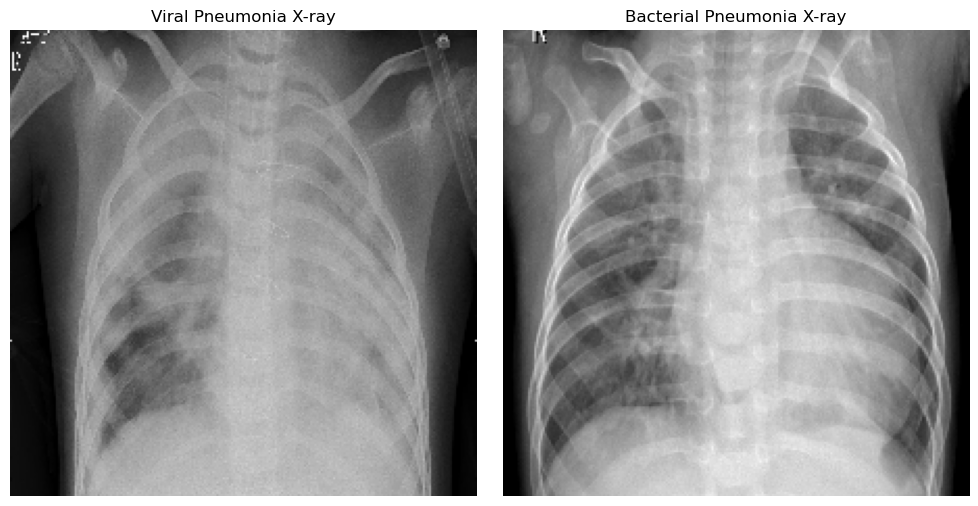

Saved Viral X-ray: saved_xrays\viral_pneumonia_xray.png
Saved Bacterial X-ray: saved_xrays\bacterial_pneumonia_xray.png


In [48]:
# Create a folder to save images if it doesn't exist
output_folder = "saved_xrays" # New created folder name.
os.makedirs(output_folder, exist_ok=True)

# Plot the images
fig = plt.figure(figsize=(10, 5)) 
axes = fig.subplots(1, 2)

# Viral Pneumonia X-ray
axes[0].imshow(viral_xray, cmap="gray")
axes[0].set_title("Viral Pneumonia X-ray")
axes[0].axis("off")
viral_path = os.path.join(output_folder, "viral_pneumonia_xray.png") # defines the file path to be saved at.
plt.imsave(viral_path, viral_xray, cmap="gray")

# Bacterial Pneumonia X-ray
axes[1].imshow(bacterial_xray, cmap="gray")
axes[1].set_title("Bacterial Pneumonia X-ray")
axes[1].axis("off")
bacterial_path = os.path.join(output_folder, "bacterial_pneumonia_xray.png")
plt.imsave(bacterial_path, bacterial_xray, cmap="gray")

plt.tight_layout()
plt.show()

print(f"Saved Viral X-ray: {viral_path}")
print(f"Saved Bacterial X-ray: {bacterial_path}")

In [49]:
# Load the trained model.
model = tf.keras.models.load_model(r"C:\Users\arifm\Desktop\Digital Futures\Training\Capstone\models\model_4")

# Print model summary to verify structure.
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [50]:
def compute_gradcam(model, img_array, class_idx=None, layer_name=None):
    """
    Computes Grad-CAM heatmap for a given image and model.
    
    Parameters:
    - model: Trained CNN model.
    - img_array: Preprocessed input image (224, 224, 3).
    - class_idx: Target class index for Grad-CAM.
    - layer_name: Convolutional layer to extract activations.
    
    Returns:
    - Heatmap of important regions
    """
    # Extract model's output and chosen convolutional layer.
    grad_model = tf.keras.models.Model(
        inputs=model.input, # Model input.
        outputs=[model.get_layer(layer_name).output, model.output] # Allows to track both the feature maps and the final predictions.
    )

    # Compute gradients.
    with tf.GradientTape() as tape: # Keeps track of gradient flowing through the selected layer.
        conv_outputs, predictions = grad_model(np.expand_dims(img_array, axis=0), training=False) # Passes image through model. outputs the feature maps from the selected convolutional layer and the model's final output.
        if class_idx is None:
            class_idx = np.argmax(predictions) # Provided predicted class.
        loss = predictions[:, class_idx] # Defines the loss as the predicted probability of the selected class and used to compute gradients relative to the chosen class.

    grads = tape.gradient(loss, conv_outputs) # Computes the gradients of the loss with respect to the feature maps.
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))  # Average gradients across all spatial locations.

    # Compute weighted activation map.
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1) # Multiplies the importance weights by their respective feature maps and sums across all channels creating a 2D heatmap.
    
    # Normalise heatmap.
    heatmap = tf.maximum(heatmap, 0)  # Keep only positive activations
    heatmap = heatmap / (tf.reduce_max(heatmap) + 1e-8)  # Normalise so that values range from 0 to 1 (avoid division by zero)

    # Invert heatmap intensity.
    heatmap = 1 - heatmap.numpy().squeeze()

    return heatmap

In [51]:
def preprocess_image(img_array):
    """
    Converts grayscale images (1 channel) to 3-channel images (RGB format)
    to match the input shape expected by the model.
    
    Parameters:
    - img_array: NumPy array of the image (224, 224, 1 or 224, 224)
    
    Returns:
    - Processed 3-channel image (224, 224, 3)
    """
    if len(img_array.shape) == 2 or img_array.shape[-1] == 1: # Checks if the channel dimension is 1 or 2.
        img_array = np.repeat(img_array[..., np.newaxis], 3, axis=-1)  # Convert to (224, 224, 3).
    
    return img_array

# Apply the fix before passing images to Grad-CAM.
viral_xray = preprocess_image(viral_xray)
bacterial_xray = preprocess_image(bacterial_xray)

print("Updated shape of Viral X-ray:", viral_xray.shape)
print("Updated shape of Bacterial X-ray:", bacterial_xray.shape)

Updated shape of Viral X-ray: (224, 224, 3)
Updated shape of Bacterial X-ray: (224, 224, 3)


In [52]:
# Choose the last convolutional layer.
bact_last_conv_layer = "sep_conv4" 
viral_last_conv_layer = "sep_conv3"

# Get Grad-CAM heatmaps.
viral_heatmap = compute_gradcam(model, viral_xray, class_idx=1, layer_name=viral_last_conv_layer)
bacterial_heatmap = compute_gradcam(model, bacterial_xray, class_idx=2, layer_name=bact_last_conv_layer)

# Resize heatmaps to match the image size.
viral_heatmap = cv2.resize(viral_heatmap, (224, 224)) # Resize from (5,4) to (224,224).
bacterial_heatmap = cv2.resize(bacterial_heatmap, (224, 224)) # Resize from (4,5) to (224,224).

In [53]:
def overlay_heatmap(img, heatmap, alpha=0.3):
    """
    Overlays a Grad-CAM heatmap onto an original grayscale X-ray image.
    Ensures proper blending with correct scaling and color mapping.
    """
    # Normalise heatmap to [0,1].
    heatmap = np.nan_to_num(heatmap)  # Replace NaN or inf values with 0.
    heatmap = (heatmap - np.min(heatmap)) / (np.max(heatmap) - np.min(heatmap) + 1e-10)  # Normalise the heatmap.
    
    # Convert heatmap to uint8 format (0-255).
    heatmap = np.uint8(255 * heatmap) # Scale to integer format [0,255] (required for OpenCV colour mapping).
    
    # Apply color map.
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET) # Converts the heatmap from greyscale to colourmap. Blue less important and red most important.

    # Ensure image is grayscale and convert it to 3-channel for overlaying
    if len(img.shape) == 2 or img.shape[-1] == 1:
        img_color = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR) # Create a 3-channel version.
    else:
        img_color = img

    # Normalises X_ray image to range [0,255] and converts to integer to work with OpenCV.
    img_color = np.uint8(255 * (img_color - np.min(img_color)) / (np.max(img_color) - np.min(img_color) + 1e-10))

    # Blend heatmap with original image
    overlay = cv2.addWeighted(img_color, 0.7, heatmap, alpha, 0) # X ray contributes 70% and heatmap contributes to 30%. 0 added to avoid shifting brightness.

    return overlay

# Apply heatmap overlay
viral_overlay = overlay_heatmap(viral_xray, viral_heatmap)
bacterial_overlay = overlay_heatmap(bacterial_xray, bacterial_heatmap)

print(viral_overlay.shape)
print(bacterial_overlay.shape)

(224, 224, 3)
(224, 224, 3)


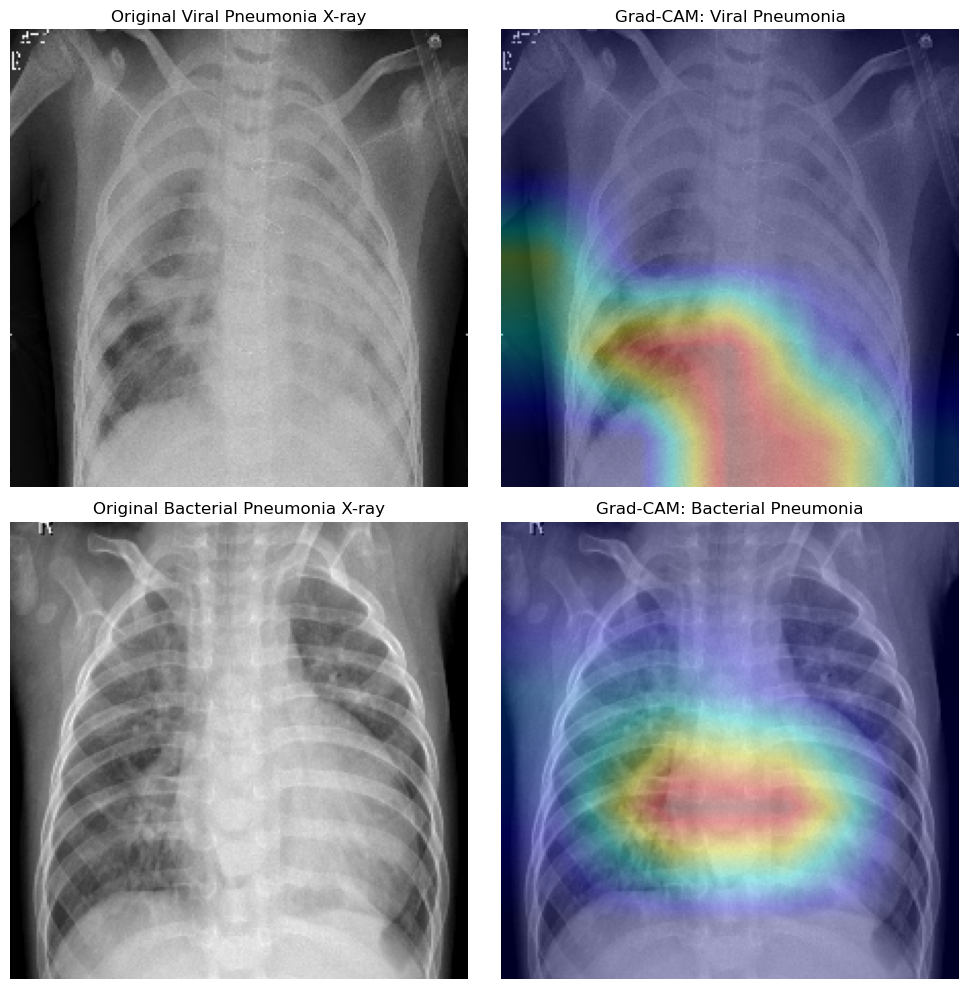

Saved Viral Grad-CAM: gradcam_results\gradcam_viral.png
Saved Bacterial Grad-CAM: gradcam_results\gradcam_bacterial.png


In [54]:
# Create folder to save Grad-CAM results
output_folder = "gradcam_results" # Folder name.
os.makedirs(output_folder, exist_ok=True)

# Save paths.
viral_cam_path = os.path.join(output_folder, "gradcam_viral.png")
bacterial_cam_path = os.path.join(output_folder, "gradcam_bacterial.png")

# Plot images.
fig = plt.figure(figsize=(10, 10))
axes = fig.subplots(2, 2)

# Original Viral Pneumonia X-ray.
axes[0, 0].imshow(viral_xray, cmap="gray")
axes[0, 0].set_title("Original Viral Pneumonia X-ray")
axes[0, 0].axis("off")

# Grad-CAM for Viral Pneumonia.
axes[0, 1].imshow(viral_overlay)
axes[0, 1].set_title("Grad-CAM: Viral Pneumonia")
axes[0, 1].axis("off")
plt.imsave(viral_cam_path, viral_overlay)

# Original Bacterial Pneumonia X-ray.
axes[1, 0].imshow(bacterial_xray, cmap="gray")
axes[1, 0].set_title("Original Bacterial Pneumonia X-ray")
axes[1, 0].axis("off")

# Grad-CAM for Bacterial Pneumonia.
axes[1, 1].imshow(bacterial_overlay)
axes[1, 1].set_title("Grad-CAM: Bacterial Pneumonia")
axes[1, 1].axis("off")
plt.imsave(bacterial_cam_path, bacterial_overlay)

plt.tight_layout()
plt.show()

print(f"Saved Viral Grad-CAM: {viral_cam_path}")
print(f"Saved Bacterial Grad-CAM: {bacterial_cam_path}")

In [55]:
viral_xray.shape

(224, 224, 3)

In [56]:
viral_xray = np.expand_dims(viral_xray, axis=0)  # Increases the image dimension to have batch size.
bacterial_xray = np.expand_dims(bacterial_xray, axis=0) # Increases the image dimension to have batch size.

In [57]:
viral_xray.shape

(1, 224, 224, 3)

In [58]:
bacterial_xray.shape

(1, 224, 224, 3)

In [59]:
# Make predictions
bacterial_pred = model.predict(bacterial_xray)
viral_pred = model.predict(viral_xray)

1/1 [==============================] - 0s 34ms/step


In [60]:
# Get predicted class indices
bacterial_class = np.argmax(bacterial_pred)  # Class with highest probability
viral_class = np.argmax(viral_pred)

# Define class labels (assuming 0=Normal, 1=Viral, 2=Bacterial)
class_labels = {0: "Normal", 1: "Viral Pneumonia", 2: "Bacterial Pneumonia"}

# Print results
print(f"Bacterial X-ray Prediction: {class_labels[bacterial_class]} ({bacterial_pred.max():.2f} confidence)")
print(f"Viral X-ray Prediction: {class_labels[viral_class]} ({viral_pred.max():.2f} confidence)")

Bacterial X-ray Prediction: Bacterial Pneumonia (0.76 confidence)
Viral X-ray Prediction: Bacterial Pneumonia (0.73 confidence)


In [61]:
bacterial_pred

array([[1.5030985e-05, 2.4469353e-01, 7.5529140e-01]], dtype=float32)

In [62]:
viral_pred

array([[4.5930115e-05, 2.7319488e-01, 7.2675920e-01]], dtype=float32)

# Testing

In [63]:
# Convert one-hot encoded y_test to class labels
y_true = np.argmax(y_test, axis=1)

In [69]:
y_true

array([2, 0, 0, ..., 1, 2, 0], dtype=int64)

In [65]:
# Get model predictions
y_pred_probs = model.predict(X_test)  # Probabilities
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert to class labels

37/37 [==============================] - 16s 431ms/step


In [66]:
len(y_pred)

1172

In [67]:
# Assuming y_true (true labels) and y_pred (predicted labels from the model)
print("Accuracy:", accuracy_score(y_true, y_pred))
print("Precision:", precision_score(y_true, y_pred, average="weighted"))
print("Recall:", recall_score(y_true, y_pred, average="weighted"))
print("F1-score:", f1_score(y_true, y_pred, average="weighted"))
print("AUC-ROC:", roc_auc_score(y_true, y_pred_probs, multi_class="ovr"))

# Print classification report
print(classification_report(y_true, y_pred))

Accuracy: 0.7960750853242321
Precision: 0.7895597475700261
Recall: 0.7960750853242321
F1-score: 0.7890025177538417
AUC-ROC: 0.9078830766023199
              precision    recall  f1-score   support

           0       0.94      0.91      0.93       317
           1       0.64      0.50      0.56       299
           2       0.78      0.89      0.83       556

    accuracy                           0.80      1172
   macro avg       0.79      0.77      0.77      1172
weighted avg       0.79      0.80      0.79      1172



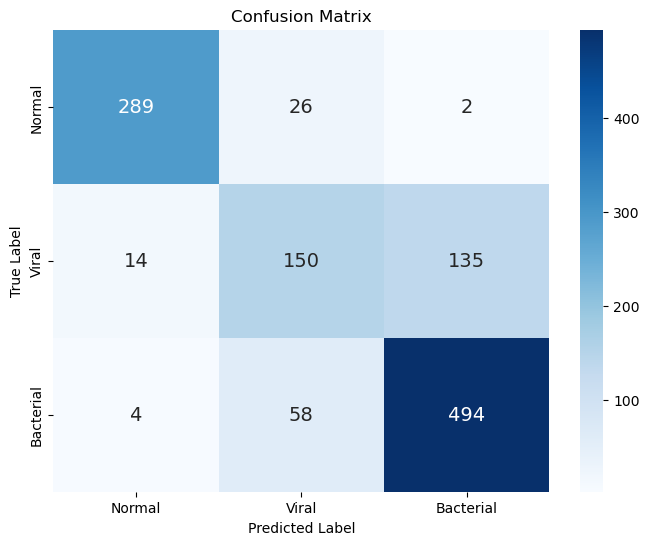

In [68]:
# Compute Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Plot
plt.figure(figsize=(8,6))  # Increase figure size
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
            xticklabels=["Normal", "Viral", "Bacterial"],
            yticklabels=["Normal", "Viral", "Bacterial"],
            annot_kws={"size": 14})  # Increase annotation size
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

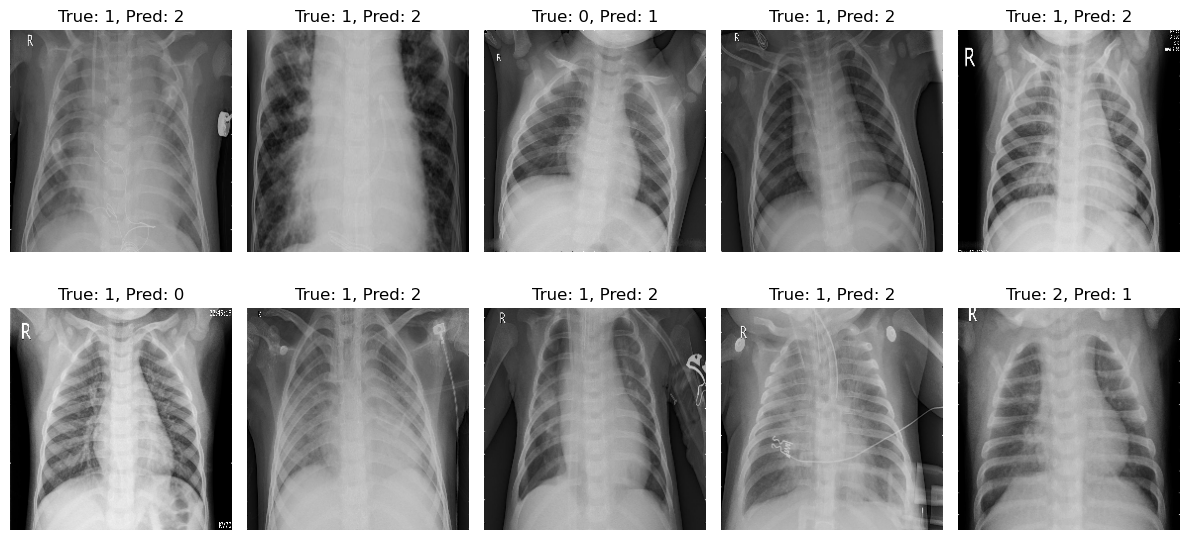

In [71]:
misclassified_indices = np.where(y_true != y_pred)[0]

# Plot a few misclassified X-rays
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
    idx = misclassified_indices[i]
    ax.imshow(X_test[idx], cmap='gray')
    ax.set_title(f"True: {y_true[idx]}, Pred: {y_pred[idx]}")
    ax.axis('off')

plt.tight_layout()
plt.show()

## Need to do:
- Train the model more
- compare the performance to full VGG16
- Start with the layout of presentation